In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [47]:
# --- Funções de Leitura de Dados ---

def read_conllu_file(filepath):
    """
    Read a CoNLL-U format file and extract words and POS tags sentence by sentence.
    
    Args:
        filepath: Path to the CoNLL-U file
        
    Returns:
        A list of dictionaries, each containing 'words' and 'pos_tags' lists for a sentence
    """
    sentences = []
    current_sentence = {'words': [], 'pos_tags': []}
    
    with open(filepath, "r", encoding="utf-8") as data_file:
        for line in data_file:
            if line.startswith("#"):
                # Skip comment lines
                pass
            elif line.strip() == "":
                # Empty line marks end of sentence
                if current_sentence['words']:  # Only add non-empty sentences
                    sentences.append(current_sentence)
                    current_sentence = {'words': [], 'pos_tags': []}
            else:
                # Parse the token line
                fields = line.split("\t")
                word, pos = fields[1], fields[3]
                current_sentence['words'].append(word)
                current_sentence['pos_tags'].append(pos)
    
    return sentences

#load data
TRAIN = "./data/en_ewt-ud-train.conllu"
DEV = "./data/en_ewt-ud-dev.conllu"
TEST = "./data/en_ewt-ud-test.conllu"
GLOVE300 = "../Part1/data/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"

# --- 1) Carregar Dados ---
try:
    train_sents = read_conllu_file(TRAIN)
    val_sents = read_conllu_file(DEV)
    test_sents = read_conllu_file(TEST)
    print("Loaded sentences:", len(train_sents), len(val_sents), len(test_sents))
except FileNotFoundError as e:
    print(f"Erro: Ficheiro de dados não encontrado: {e.filename}. Certifique-se de que os ficheiros CoNLL-U estão em './data/'")
    exit()

# Display preview
print(f"Total sentences: {len(val_sents)}")
print(f"First 3 sentences:")
for i, sent in enumerate(val_sents[:3]):
    print(f"Sentence {i+1}:")
    print(f"  Words: {sent['words']}")
    print(f"  POS tags: {sent['pos_tags']}")

Loaded sentences: 12544 2001 2077
Total sentences: 2001
First 3 sentences:
Sentence 1:
  Words: ['From', 'the', 'AP', 'comes', 'this', 'story', ':']
  POS tags: ['ADP', 'DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']
Sentence 2:
  Words: ['President', 'Bush', 'on', 'Tuesday', 'nominated', 'two', 'individuals', 'to', 'replace', 'retiring', 'jurists', 'on', 'federal', 'courts', 'in', 'the', 'Washington', 'area', '.']
  POS tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PART', 'VERB', 'VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'PUNCT']
Sentence 3:
  Words: ['Bush', 'nominated', 'Jennifer', 'M.', 'Anderson', 'for', 'a', '15', '-', 'year', 'term', 'as', 'associate', 'judge', 'of', 'the', 'Superior', 'Court', 'of', 'the', 'District', 'of', 'Columbia', ',', 'replacing', 'Steffen', 'W.', 'Graae', '.']
  POS tags: ['PROPN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADP', 'DET', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'PROP

In [48]:
# --- Constants ---
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
BATCH_SIZE = 32
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# --- Vocabulary Helpers ---
def build_vocab(sentences, min_freq=1):
    """Builds word and tag vocabularies from the dataset."""
    word_freq = {}
    tag_set = set()
    
    for sent in sentences:
        for word, tag in zip(sent['words'], sent['pos_tags']):
            word_freq[word] = word_freq.get(word, 0) + 1
            tag_set.add(tag)
            
    # Mappings: Word to Index
    word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    idx2word = {0: PAD_TOKEN, 1: UNK_TOKEN}
    
    current_idx = 2
    for word, freq in word_freq.items():
        if freq >= min_freq:
            word2idx[word] = current_idx
            idx2word[current_idx] = word
            current_idx += 1
            
    # Mappings: Tag to Index
    tag2idx = {PAD_TOKEN: 0}
    idx2tag = {0: PAD_TOKEN}
    
    current_idx = 1
    for tag in sorted(list(tag_set)):
        tag2idx[tag] = current_idx
        idx2tag[current_idx] = tag
        current_idx += 1
        
    return word2idx, tag2idx

# Build vocab based on TRAIN set only to avoid data leakage~
word2idx, tag2idx = build_vocab(train_sents)
idx2tag = {v: k for k, v in tag2idx.items()}

print(f"\nVocab Size: {len(word2idx)}")
vocab_size = len(word2idx)
print(f"Tagset Size: {len(tag2idx)}")
num_tags = len(tag2idx)


Vocab Size: 20203
Tagset Size: 19


In [49]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim,
                          unk_token="<unk>", lower=True,
                          random_seed=42, scale=0.05,
                          save_numpy_path=None):
    """
    Load GloVe text file into a numpy array shaped (vocab_size, embedding_dim)
    aligned with word2idx. Words not found in GloVe get small random vectors.

    Args:
      glove_path (str): path to GloVe text file (each line: word v1 v2 ...).
      word2idx (dict): mapping word -> index that your model uses.
      embedding_dim (int): expected embedding dim (e.g., 300).
      unk_token (str): token used for unknown word index (if present in word2idx).
      lower (bool): match lowercase words to GloVe entries.
      random_seed (int), scale (float): initializer params for OOV vectors.
      save_numpy_path (str|None): if provided, saves the numpy array for faster reload.

    Returns:
      np.ndarray shape (vocab_size, embedding_dim)
    """
    rng = np.random.RandomState(random_seed)
    vocab_size = len(word2idx)
    # initialize with small random values
    embeddings = rng.normal(loc=0.0, scale=scale, size=(vocab_size, embedding_dim)).astype(np.float32)

    # Optional: set a fixed vector for padding or unk if you want zeros
    if "<pad>" in word2idx:
        embeddings[word2idx["<pad>"]] = np.zeros(embedding_dim, dtype=np.float32)
    if unk_token in word2idx:
        embeddings[word2idx[unk_token]] = rng.normal(loc=0.0, scale=scale, size=(embedding_dim,)).astype(np.float32)

    found = 0
    with open(glove_path, "r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            parts = line.rstrip().split(" ")
            if len(parts) <= embedding_dim:
                # malformed line
                continue
            word = parts[0]
            if lower:
                key = word.lower()
            else:
                key = word
            try:
                vec = np.asarray(parts[1:], dtype=np.float32)
            except ValueError:
                # bad numeric conversion
                continue
            if vec.shape[0] != embedding_dim:
                continue
            # check if word is in our vocab (try exact and lower forms)
            if key in word2idx:
                embeddings[word2idx[key]] = vec
                found += 1
            # sometimes your vocab has forms like "dog" and GloVe has "dog," etc.
            # but try to keep matching simple to avoid false positives.

    print(f"Loaded GloVe: found {found}/{vocab_size} words from the provided vocabulary.")
    if save_numpy_path:
        np.save(save_numpy_path, embeddings)
        print(f"Saved embeddings numpy to {save_numpy_path}")
    return embeddings

glove_embeddings_matrix = load_glove_embeddings(GLOVE300, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

Loaded GloVe: found 11861/20203 words from the provided vocabulary.


In [50]:
class POSDataset(Dataset):
    def __init__(self, sentences, word2idx, tag2idx):
        self.data = []
        for sent in sentences:
            # Convert words to indices (use UNK if not found)
            word_indices = [word2idx.get(w, word2idx[UNK_TOKEN]) for w in sent['words']]
            # Convert tags to indices
            tag_indices = [tag2idx[t] for t in sent['pos_tags']]
            self.data.append((torch.tensor(word_indices), torch.tensor(tag_indices)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    """Pads sequences so they are all the same length in a batch."""
    words, tags = zip(*batch)
    words_padded = pad_sequence(words, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)
    return words_padded, tags_padded

# Initialize DataLoaders
train_data = POSDataset(train_sents, word2idx, tag2idx)
test_data = POSDataset(test_sents, word2idx, tag2idx)
val_data = POSDataset(val_sents, word2idx, tag2idx)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [51]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, num_layers=1, pretrained_embeddings=None):
        super(LSTMTagger, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Load Glove embeddings if provided
        if pretrained_embeddings is not None:
            print("Loading pretrained embeddings...")
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # Output Layer: hidden_dim * 2 because of bidirectionality
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embeds = self.dropout(self.embedding(x))
        
        # lstm_out shape: (batch_size, seq_len, hidden_dim * 2)
        lstm_out, _ = self.lstm(embeds)
        
        # predictions shape: (batch_size, seq_len, tagset_size)
        logits = self.fc(self.dropout(lstm_out))
        return logits

In [52]:
def train_model(model, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001):
    
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)

            outputs = outputs.view(-1, outputs.shape[-1])
            batch_labels = batch_labels.view(-1)

            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                outputs = outputs.view(-1, outputs.shape[-1])
                batch_labels = batch_labels.view(-1)

                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [53]:
# Model Initialization
model = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in model.parameters())}")

Loading pretrained embeddings...
LSTM Model parameters: 6506103


In [54]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time



Starting Training...
Epoch [1/10], Train Loss: 0.7073, Val Loss: 0.3284
Epoch [2/10], Train Loss: 0.2159, Val Loss: 0.2616
Epoch [3/10], Train Loss: 0.1346, Val Loss: 0.2454
Epoch [4/10], Train Loss: 0.0967, Val Loss: 0.2496
Epoch [5/10], Train Loss: 0.0748, Val Loss: 0.2532
Epoch [6/10], Train Loss: 0.0587, Val Loss: 0.2566
Epoch [7/10], Train Loss: 0.0486, Val Loss: 0.2647
Epoch [8/10], Train Loss: 0.0394, Val Loss: 0.2890
Epoch [9/10], Train Loss: 0.0343, Val Loss: 0.2977
Epoch [10/10], Train Loss: 0.0279, Val Loss: 0.3020


In [55]:
def evaluate_model(model, dataloader, idx2tag, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for words, tags in dataloader:
            words, tags = words.to(device), tags.to(device)
            outputs = model(words)
            
            predictions = torch.argmax(outputs, dim=2)
            
            # Mask out padding tokens (index 0) so they don't affect accuracy
            mask = (tags != 0)
            valid_preds = torch.masked_select(predictions, mask)
            valid_labels = torch.masked_select(tags, mask)
            
            all_preds.extend(valid_preds.cpu().numpy())
            all_labels.extend(valid_labels.cpu().numpy())
            
    # Convert indices back to tag strings
    # We use sorted unique labels from the data to ensure alignment
    unique_labels = sorted(list(set(all_labels)))
    target_names = [idx2tag[i] for i in unique_labels]
    
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, zero_division=0)
    
    return acc, report

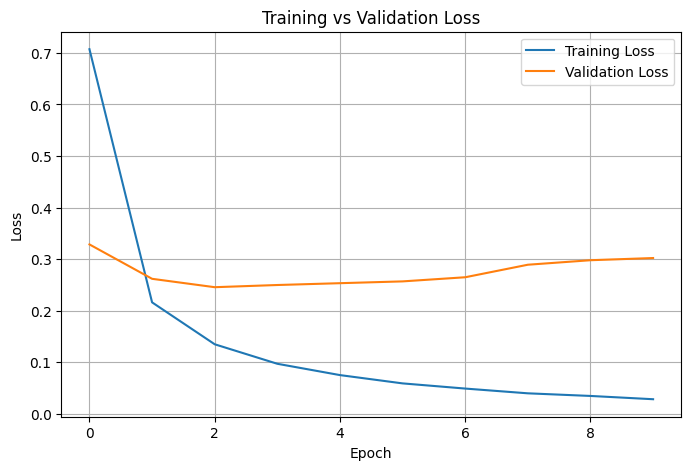

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
acc, report = evaluate_model(model, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 92.90%
Training time: 238.7124
Report:               precision    recall  f1-score   support

         ADJ       0.93      0.86      0.89      1788
         ADP       0.95      0.97      0.96      2025
         ADV       0.93      0.91      0.92      1191
         AUX       0.98      0.98      0.98      1543
       CCONJ       0.99      0.99      0.99       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.96      0.76      0.85       121
        NOUN       0.84      0.92      0.88      4123
         NUM       0.95      0.70      0.81       542
        PART       0.98      0.97      0.98       649
        PRON       0.99      0.99      0.99      2165
       PROPN       0.78      0.78      0.78      2075
       PUNCT       1.00      0.99      0.99      3096
       SCONJ       0.92      0.86      0.89       384
         SYM       0.82      0.89      0.86       113
        VERB       0.95      0.94      0.94      2606
           X       0.20      0.0

Teste para 100 DIM Embbedings

In [62]:
EMBEDDING_DIM = 100
GLOVE100 = "../Part1/data/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt"

glove_embeddings_matrix = load_glove_embeddings(GLOVE100, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

model = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in model.parameters())}")

Loaded GloVe: found 12299/20203 words from the provided vocabulary.
Loading pretrained embeddings...
LSTM Model parameters: 2260703


In [63]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time


Starting Training...
Epoch [1/10], Train Loss: 0.9106, Val Loss: 0.4287
Epoch [2/10], Train Loss: 0.3276, Val Loss: 0.3160
Epoch [3/10], Train Loss: 0.2240, Val Loss: 0.2727
Epoch [4/10], Train Loss: 0.1692, Val Loss: 0.2590
Epoch [5/10], Train Loss: 0.1383, Val Loss: 0.2500
Epoch [6/10], Train Loss: 0.1154, Val Loss: 0.2453
Epoch [7/10], Train Loss: 0.0991, Val Loss: 0.2453
Epoch [8/10], Train Loss: 0.0865, Val Loss: 0.2541
Epoch [9/10], Train Loss: 0.0770, Val Loss: 0.2521
Epoch [10/10], Train Loss: 0.0685, Val Loss: 0.2616


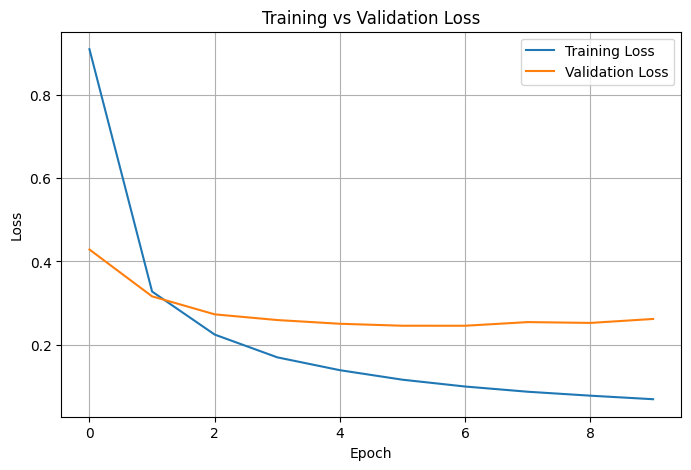

In [64]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
acc, report = evaluate_model(model, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 93.09%
Training time: 143.5672
Report:               precision    recall  f1-score   support

         ADJ       0.93      0.86      0.89      1788
         ADP       0.95      0.97      0.96      2025
         ADV       0.94      0.90      0.92      1191
         AUX       0.98      0.99      0.98      1543
       CCONJ       1.00      0.99      0.99       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.95      0.77      0.85       121
        NOUN       0.89      0.89      0.89      4123
         NUM       0.95      0.74      0.83       542
        PART       0.97      0.98      0.98       649
        PRON       0.99      0.98      0.98      2165
       PROPN       0.72      0.87      0.79      2075
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.90      0.86      0.88       384
         SYM       0.93      0.84      0.88       113
        VERB       0.95      0.93      0.94      2606
           X       0.17      0.0

Teste para 200 DIM Embbedings

In [66]:
EMBEDDING_DIM = 200
GLOVE200 = "../Part1/data/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"

glove_embeddings_matrix = load_glove_embeddings(GLOVE200, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

model = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in model.parameters())}")

Loaded GloVe: found 12299/20203 words from the provided vocabulary.
Loading pretrained embeddings...
LSTM Model parameters: 4383403


In [67]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time


Starting Training...
Epoch [1/10], Train Loss: 0.7696, Val Loss: 0.3579
Epoch [2/10], Train Loss: 0.2512, Val Loss: 0.2749
Epoch [3/10], Train Loss: 0.1626, Val Loss: 0.2620
Epoch [4/10], Train Loss: 0.1192, Val Loss: 0.2471
Epoch [5/10], Train Loss: 0.0932, Val Loss: 0.2524
Epoch [6/10], Train Loss: 0.0760, Val Loss: 0.2559
Epoch [7/10], Train Loss: 0.0638, Val Loss: 0.2718
Epoch [8/10], Train Loss: 0.0549, Val Loss: 0.2782
Epoch [9/10], Train Loss: 0.0468, Val Loss: 0.2765
Epoch [10/10], Train Loss: 0.0403, Val Loss: 0.3066


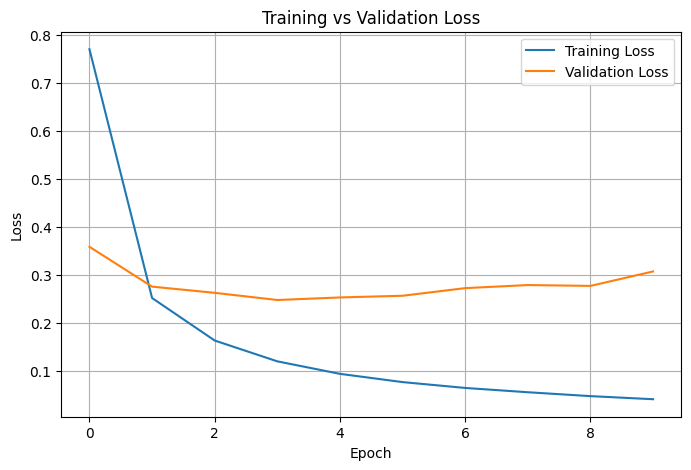

In [68]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
acc, report = evaluate_model(model, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 92.27%
Training time: 210.3265
Report:               precision    recall  f1-score   support

         ADJ       0.87      0.88      0.88      1788
         ADP       0.95      0.97      0.96      2025
         ADV       0.94      0.89      0.91      1191
         AUX       0.99      0.99      0.99      1543
       CCONJ       0.99      0.99      0.99       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.95      0.77      0.85       121
        NOUN       0.79      0.94      0.86      4123
         NUM       0.97      0.70      0.81       542
        PART       0.97      0.98      0.97       649
        PRON       0.98      0.99      0.99      2165
       PROPN       0.87      0.65      0.74      2075
       PUNCT       1.00      0.99      0.99      3096
       SCONJ       0.90      0.86      0.88       384
         SYM       0.87      0.87      0.87       113
        VERB       0.95      0.93      0.94      2606
           X       0.08      0.0